In [45]:
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from soilgasflux_fcs import json_reader, models, metrics
import xarray as xr
from scipy.stats import binned_statistic
import warnings
import pandas as pd
import json
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
folder_base = pathlib.Path(r'/Users/alexnaokiasatokobayashi/Documents/FCS/raw_data/test05/')
folder_Commercial = pathlib.Path(r'/Users/alexnaokiasatokobayashi/Documents/FCS/raw_data/test06/')
folder_LowCost = pathlib.Path(r'/Users/alexnaokiasatokobayashi/Documents/FCS/raw_data/test07/')

df_base = pd.DataFrame()
for file in folder_base.rglob('*.json'):
    with open(file, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data['raw_data'])
    df['id'] = file.name
    df['alpha'] = data['config']['alpha']
    df['cs'] = data['config']['c_s']
    df['c0'] = data['config']['c_c0']
    df['t0'] = data['config']['t0']
    df['curvature'] = data['config']['curvature']  
    df_base = pd.concat([df_base, df], axis=0)

df_commercial = pd.DataFrame()
for file in folder_Commercial.rglob('*.json'):
    with open(file, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data['raw_data'])
    df['id'] = file.name
    df['alpha'] = data['config']['alpha']
    df['cs'] = data['config']['c_s']
    df['c0'] = data['config']['c_c0']
    df['t0'] = data['config']['t0']
    df['curvature'] = data['config']['curvature']
    df_commercial = pd.concat([df_commercial, df], axis=0)

df_lowcost = pd.DataFrame()
for file in folder_LowCost.rglob('*.json'):
    with open(file, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data['raw_data'])
    df['id'] = file.name
    df['alpha'] = data['config']['alpha']
    df['cs'] = data['config']['c_s']
    df['c0'] = data['config']['c_c0']
    df['t0'] = data['config']['t0']
    df['curvature'] = data['config']['curvature']
    df_lowcost = pd.concat([df_lowcost, df], axis=0)

In [47]:
for i in df_lowcost['id'].unique():
    df = df_lowcost[df_lowcost['id'] == i]
    max_co2 = df['k30_co2'].max()
    min_co2 = df['k30_co2'].min()
    if max_co2 - min_co2 < 60:
        df_lowcost.loc[df_lowcost['id']==i, 'intensity'] = 'low'
    elif (max_co2 - min_co2 < 120)& (max_co2 - min_co2 >= 60):
        df_lowcost.loc[df_lowcost['id']==i, 'intensity'] = 'medium'
    elif max_co2 - min_co2 >= 120:
        df_lowcost.loc[df_lowcost['id']==i, 'intensity'] = 'high'

for i in df_commercial['id'].unique():
    df = df_commercial[df_commercial['id'] == i]
    max_co2 = df['k30_co2'].max()
    min_co2 = df['k30_co2'].min()
    if max_co2 - min_co2 < 60:
        df_commercial.loc[df_commercial['id']==i, 'intensity'] = 'low'
    elif (max_co2 - min_co2 < 120)& (max_co2 - min_co2 >= 60):
        df_commercial.loc[df_commercial['id']==i, 'intensity'] = 'medium'
    elif max_co2 - min_co2 >= 120:
        df_commercial.loc[df_commercial['id']==i, 'intensity'] = 'high'
for i in df_base['id'].unique():
    df = df_base[df_base['id'] == i]
    max_co2 = df['k30_co2'].max()
    min_co2 = df['k30_co2'].min()
    if max_co2 - min_co2 < 60:
        df_base.loc[df_base['id']==i, 'intensity'] = 'low'
    elif (max_co2 - min_co2 < 120)& (max_co2 - min_co2 >= 60):
        df_base.loc[df_base['id']==i, 'intensity'] = 'medium'
    elif max_co2 - min_co2 >= 120:
        df_base.loc[df_base['id']==i, 'intensity'] = 'high'

In [3]:
processed_data_path = pathlib.Path('/Users/alexnaokiasatokobayashi/Documents/FCS/processed_data/')

test_number = 7
normalizationType = 'no' #['no', 'len', 'yRange']
# add_info = '_ln_v2test4' #['', '_ln_v2', '_ln_v2test0]
add_info = '_test5'

filename_regular = f'test{test_number:02}_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_mc = f'test{test_number:02}_MC_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_expected = f'expected_test{test_number:02}_2025-05-08.nc'
print(filename_regular)
print(filename_mc)
print(filename_expected)

ds = xr.open_dataset(processed_data_path / filename_regular)
dsMC = xr.open_dataset(processed_data_path / filename_mc)
expected_ds = xr.open_dataset(processed_data_path / filename_expected)

test07_noNorm_test5_2025-05-08.nc
test07_MC_noNorm_test5_2025-05-08.nc
expected_test07_2025-05-08.nc


In [4]:
ds

<xarray.Dataset> Size: 173kB
Dimensions:        (time: 30, cutoff: 12, deadband: 6)
Coordinates:
  * time           (time) datetime64[ns] 240B 2025-05-08T15:22:56 ... 2025-05...
  * deadband       (deadband) int64 48B 0 10 20 30 40 50
  * cutoff         (cutoff) int64 96B 60 70 80 90 100 ... 130 140 150 160 170
Data variables:
    dcdt(HM)       (time, cutoff, deadband) float64 17kB ...
    dcdt(linear)   (time, cutoff, deadband) float64 17kB ...
    AIC(HM)        (time, cutoff, deadband) float64 17kB ...
    AIC(linear)    (time, cutoff, deadband) float64 17kB ...
    RMSE(HM)       (time, cutoff, deadband) float64 17kB ...
    RMSE(linear)   (time, cutoff, deadband) float64 17kB ...
    R2(HM)         (time, cutoff, deadband) float64 17kB ...
    R2(linear)     (time, cutoff, deadband) float64 17kB ...
    nRMSE(HM)      (time, cutoff, deadband) float64 17kB ...
    nRMSE(linear)  (time, cutoff, deadband) float64 17kB ...

In [127]:
arbitrary_results = {'deadband':[10,30, 30],
                    'cutoff':[70,120,170],  
                    'dcdt(HM)':[], 'dcdt(linear)':[], 'R2':[]}

In [128]:
ds.isel(time=0)['R2(HM)'].values

array([[0.52466512,        nan,        nan,        nan,        nan,
               nan],
       [0.62616909, 0.60364803,        nan,        nan,        nan,
               nan],
       [0.69313544, 0.67169856, 0.58937215,        nan,        nan,
               nan],
       [0.74185136, 0.72289179, 0.65649089, 0.60914196,        nan,
               nan],
       [0.78300807, 0.76690065, 0.71316765, 0.67619186, 0.61498123,
               nan],
       [0.80911615, 0.79391189, 0.74863706, 0.71578665, 0.6622894 ,
        0.56427527],
       [0.84097207, 0.82955294, 0.79484385, 0.77186554, 0.73404282,
        0.66416571],
       [0.85470547, 0.84372041, 0.81392675, 0.79269967, 0.75923219,
        0.70155492],
       [0.8765357 , 0.86812544, 0.84488106, 0.82927056, 0.80454871,
        0.76183553],
       [0.89669767, 0.89064077, 0.87282024, 0.86201363, 0.84446837,
        0.81345523],
       [0.91008625, 0.90507103, 0.89033147, 0.8818512 , 0.8678346 ,
        0.84284407],
       [0.92043175, 0

cm = 1/2.54
for t in ds.time:
    fig, ax1 = plt.subplots(1, 1, figsize=(19*cm, 10*cm))

    deadbands = []
    r2_values = []
    rmse_values = []
    aic_values = []

    for i, a in enumerate(zip(arbitrary_results['deadband'], arbitrary_results['cutoff'])):
        r2 = ds.sel(time=t, deadband=a[0], cutoff=a[1])['R2(HM)'].values
        rmse = ds.sel(time=t, deadband=a[0], cutoff=a[1])['RMSE(HM)'].values
        aic = ds.sel(time=t, deadband=a[0], cutoff=a[1])['AIC(HM)'].values
        
        deadbands.append(f'{a[0]}-{a[1]}')
        r2_values.append(r2)
        rmse_values.append(rmse)
        aic_values.append(aic)

    x = np.arange(len(deadbands))
    width = 0.25

    # First y-axis for R2
    bars1 = ax1.bar(x - width, r2_values, width, color='blue', alpha=0.7, label='R2(HM)')
    ax1.set_xlabel('Deadband-Cutoff')
    ax1.set_ylabel('R2(HM)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticks(x)
    ax1.set_xticklabels(deadbands)

    # Second y-axis for RMSE
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x, rmse_values, width, color='orange', alpha=0.7, label='RMSE(HM)')
    ax2.set_ylabel('RMSE(HM)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Third y-axis for AIC
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    bars3 = ax3.bar(x + width, aic_values, width, color='green', alpha=0.7, label='AIC(HM)')
    ax3.set_ylabel('AIC(HM)', color='green')
    ax3.tick_params(axis='y', labelcolor='green')

    ax1.set_title(f'Model Metrics Comparison (Time: {t.values})')
    
    # Create legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    # ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='best')
    # ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, 
    #         bbox_to_anchor=(1.15, 1), loc='upper left')
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, 
            bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=3)
    plt.tight_layout()
    fig.show()

In [129]:
ds

<xarray.Dataset> Size: 173kB
Dimensions:        (time: 30, cutoff: 12, deadband: 6)
Coordinates:
  * time           (time) datetime64[ns] 240B 2025-05-08T15:22:56 ... 2025-05...
  * deadband       (deadband) int64 48B 0 10 20 30 40 50
  * cutoff         (cutoff) int64 96B 60 70 80 90 100 ... 130 140 150 160 170
Data variables:
    dcdt(HM)       (time, cutoff, deadband) float64 17kB ...
    dcdt(linear)   (time, cutoff, deadband) float64 17kB ...
    AIC(HM)        (time, cutoff, deadband) float64 17kB ...
    AIC(linear)    (time, cutoff, deadband) float64 17kB ...
    RMSE(HM)       (time, cutoff, deadband) float64 17kB ...
    RMSE(linear)   (time, cutoff, deadband) float64 17kB ...
    R2(HM)         (time, cutoff, deadband) float64 17kB ...
    R2(linear)     (time, cutoff, deadband) float64 17kB ...
    nRMSE(HM)      (time, cutoff, deadband) float64 17kB ...
    nRMSE(linear)  (time, cutoff, deadband) float64 17kB ...

cm = 1/2.54
for t in ds.time:
    fig, ax = plt.subplots(1, 1, figsize=(19*cm, 10*cm))

    deadbands = []
    r2_values = []
    rmse_values = []
    aic_values = []

    for i, a in enumerate(zip(arbitrary_results['deadband'], arbitrary_results['cutoff'])):
        r2 = ds.sel(time=t, deadband=a[0], cutoff=a[1])['R2(HM)'].values
        rmse = ds.sel(time=t, deadband=a[0], cutoff=a[1])['RMSE(HM)'].values
        aic = ds.sel(time=t, deadband=a[0], cutoff=a[1])['AIC(HM)'].values
        
        deadbands.append(f'{a[0]}-{a[1]}')
        r2_values.append(r2)
        rmse_values.append(rmse)
        aic_values.append(aic)

    # Create rankings (1=best, higher=worse)
    # For R2: higher is better, so reverse ranking
    # r2_ranks = len(r2_values) + 1 - np.argsort(np.argsort(r2_values)[::-1]) - 1
    r2_ranks = np.argsort(np.argsort(r2_values)[::-1]) + 1
    # For RMSE and AIC: lower is better
    rmse_ranks = np.argsort(np.argsort(rmse_values)) + 1
    aic_ranks = np.argsort(np.argsort(aic_values)) + 1

    # Create bump chart
    metrics = ['R²', 'RMSE', 'AIC']
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    
    for i, combo in enumerate(deadbands):
        ranks = [r2_ranks[i], rmse_ranks[i], aic_ranks[i]]
        ax.plot(metrics, ranks, 'o-', color=colors[i % len(colors)], 
                linewidth=2, markersize=8, label=combo, alpha=0.8)
        
        # Add value labels on points
        for j, (metric, rank) in enumerate(zip(metrics, ranks)):
            if metric == 'R²':
                value = f'{r2_values[i]:.3f}'
            elif metric == 'RMSE':
                value = f'{rmse_values[i]:.3f}'
            else:
                value = f'{aic_values[i]:.1f}'
            ax.annotate(value, (j, rank), textcoords="offset points", 
                       xytext=(0,10), ha='center', fontsize=8)

    ax.set_ylabel('Rank (1=Best)')
    ax.set_xlabel('Metrics')
    ax.set_title(f'Model Performance Rankings (Time: {t.values})')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()  # Best rank (1) at top
    ax.set_ylim(len(deadbands) + 0.5, 0.5)
    
    # Legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    fig.show()

In [130]:
df_lowcost.head()

,datetime,datetime_utc,k30_co2,bmp_pressure,bmp_temperature,si_humidity,si_temperature,id,alpha,cs,c0,t0,curvature,intensity
0,0,2025-05-08 15:52:56,428.799665,99000.0,20.0,70.0,20.0,2025-5-8_15-52-56.json,0.001,1000.0,430,0,big,medium
1,1,2025-05-08 15:52:57,428.797356,99000.0,20.0,70.0,20.0,2025-5-8_15-52-56.json,0.001,1000.0,430,0,big,medium
2,2,2025-05-08 15:52:58,429.606391,99000.0,20.0,70.0,20.0,2025-5-8_15-52-56.json,0.001,1000.0,430,0,big,medium
3,3,2025-05-08 15:52:59,429.765075,99000.0,20.0,70.0,20.0,2025-5-8_15-52-56.json,0.001,1000.0,430,0,big,medium
4,4,2025-05-08 15:53:00,427.601386,99000.0,20.0,70.0,20.0,2025-5-8_15-52-56.json,0.001,1000.0,430,0,big,medium


In [131]:
ds

<xarray.Dataset> Size: 173kB
Dimensions:        (time: 30, cutoff: 12, deadband: 6)
Coordinates:
  * time           (time) datetime64[ns] 240B 2025-05-08T15:22:56 ... 2025-05...
  * deadband       (deadband) int64 48B 0 10 20 30 40 50
  * cutoff         (cutoff) int64 96B 60 70 80 90 100 ... 130 140 150 160 170
Data variables:
    dcdt(HM)       (time, cutoff, deadband) float64 17kB ...
    dcdt(linear)   (time, cutoff, deadband) float64 17kB ...
    AIC(HM)        (time, cutoff, deadband) float64 17kB ...
    AIC(linear)    (time, cutoff, deadband) float64 17kB ...
    RMSE(HM)       (time, cutoff, deadband) float64 17kB ...
    RMSE(linear)   (time, cutoff, deadband) float64 17kB ...
    R2(HM)         (time, cutoff, deadband) float64 17kB ...
    R2(linear)     (time, cutoff, deadband) float64 17kB ...
    nRMSE(HM)      (time, cutoff, deadband) float64 17kB ...
    nRMSE(linear)  (time, cutoff, deadband) float64 17kB ...

['2025-05-08 15:52:56', '2025-05-08 15:58:56', '2025-05-08 16:10:56', '2025-05-08 16:04:56', '2025-05-08 16:16:56']
['2025-05-08 16:13:56', '2025-05-08 16:19:56', '2025-05-08 16:01:56', '2025-05-08 15:55:56', '2025-05-08 16:07:56']
['2025-05-08 16:34:56', '2025-05-08 16:46:56', '2025-05-08 16:40:56', '2025-05-08 16:22:56', '2025-05-08 16:28:56']
['2025-05-08 16:25:56', '2025-05-08 16:37:56', '2025-05-08 16:49:56', '2025-05-08 16:31:56', '2025-05-08 16:43:56']
['2025-05-08 15:28:56', '2025-05-08 15:22:56', '2025-05-08 15:40:56', '2025-05-08 15:46:56', '2025-05-08 15:34:56']
['2025-05-08 15:43:56', '2025-05-08 15:31:56', '2025-05-08 15:49:56', '2025-05-08 15:37:56', '2025-05-08 15:25:56']


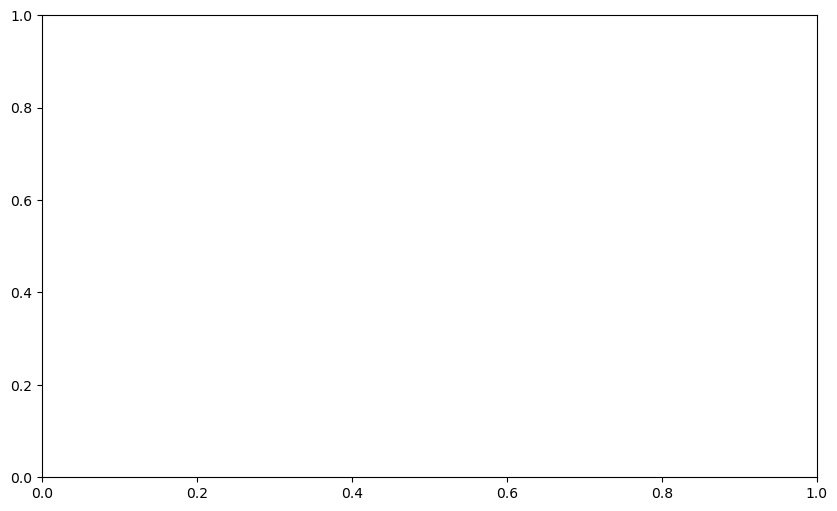

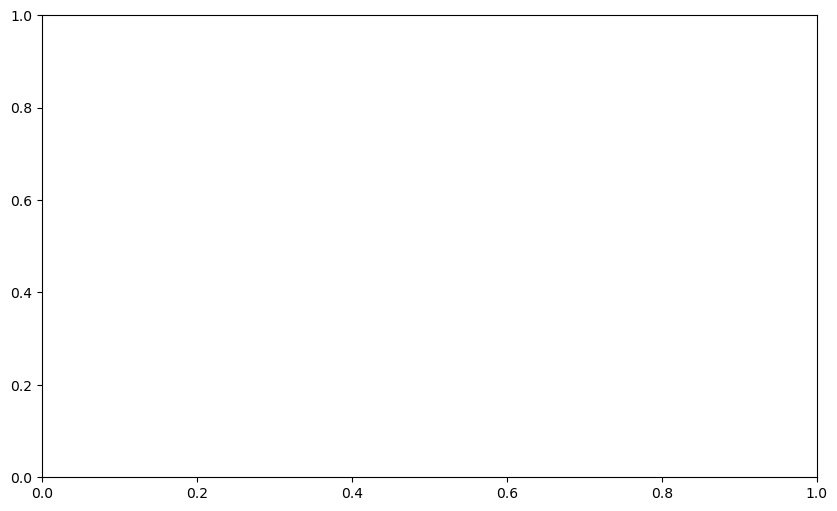

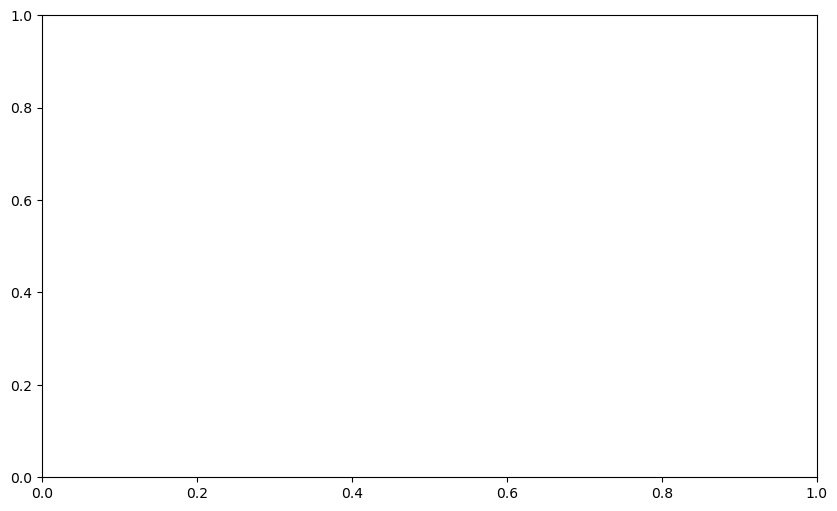

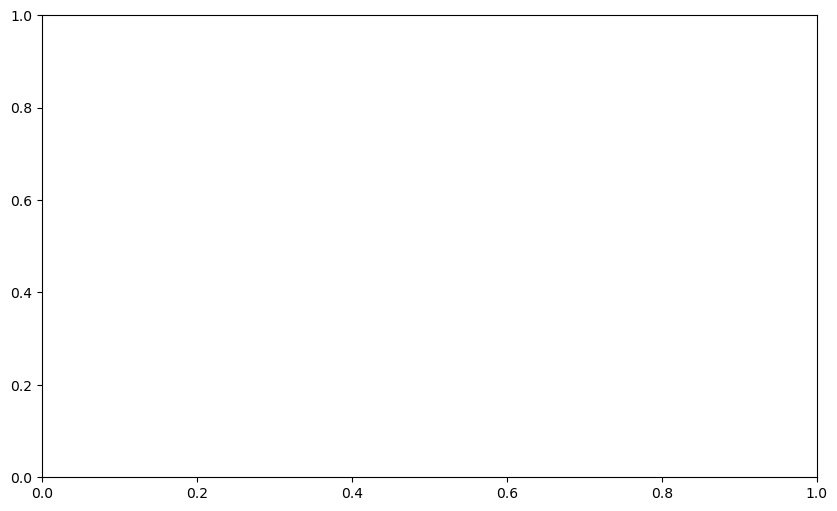

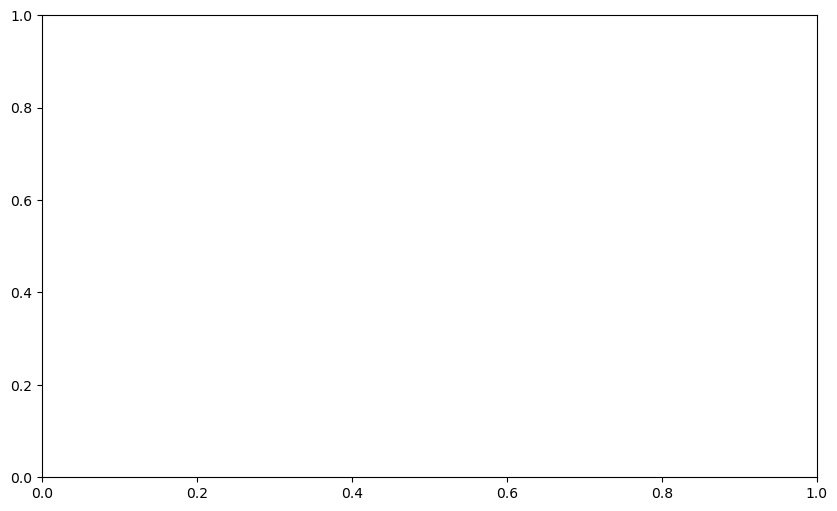

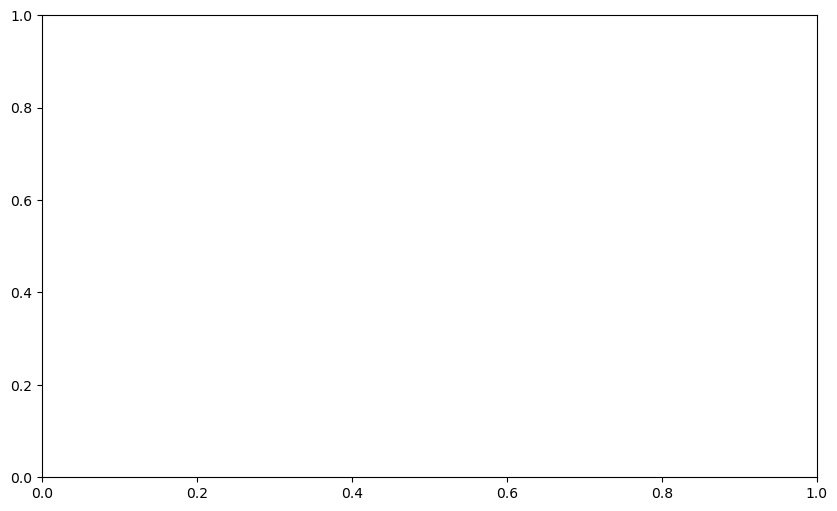

In [132]:
intensities = df_lowcost['intensity'].unique()
curvatures = df_lowcost['curvature'].unique()
for intensity in intensities:
    for curvature in curvatures:
        df = df_lowcost[(df_lowcost['intensity'] == intensity) 
                        & (df_lowcost['curvature'] == curvature)]
        ids = df['id'].unique()
        list_of_times = []
        for i in ids:
            df_i = df[df['id'] == i]
            time = df_i['datetime_utc'].values[0]
            list_of_times.append(time)
        print(list_of_times)
        fig, ax = plt.subplots(figsize=(10, 6))

        


Intensity: medium, Curvature: big
Times: ['2025-05-08 15:52:56', '2025-05-08 15:58:56', '2025-05-08 16:10:56', '2025-05-08 16:04:56', '2025-05-08 16:16:56']


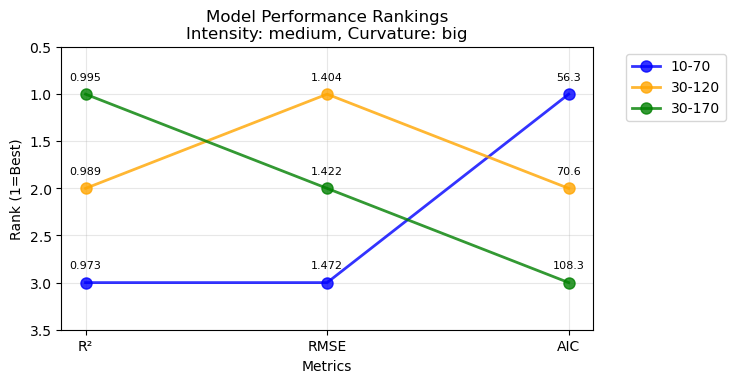

Intensity: medium, Curvature: straight
Times: ['2025-05-08 16:13:56', '2025-05-08 16:19:56', '2025-05-08 16:01:56', '2025-05-08 15:55:56', '2025-05-08 16:07:56']


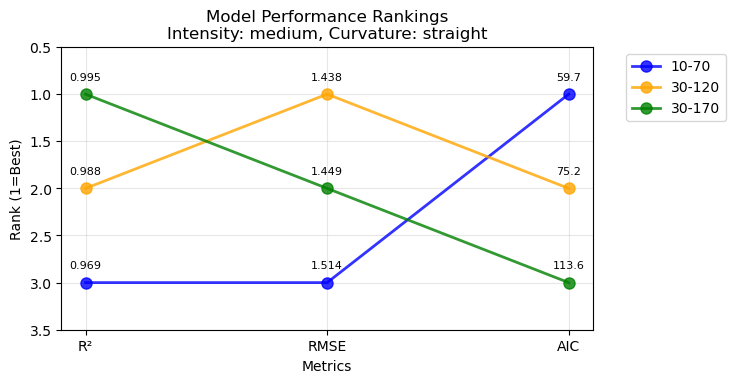

Intensity: high, Curvature: big
Times: ['2025-05-08 16:34:56', '2025-05-08 16:46:56', '2025-05-08 16:40:56', '2025-05-08 16:22:56', '2025-05-08 16:28:56']


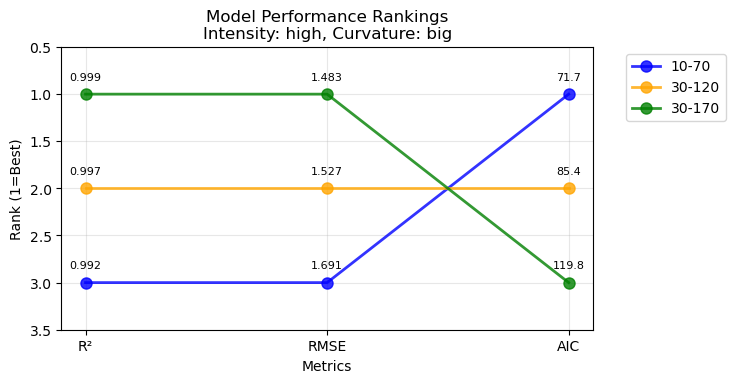

Intensity: high, Curvature: straight
Times: ['2025-05-08 16:25:56', '2025-05-08 16:37:56', '2025-05-08 16:49:56', '2025-05-08 16:31:56', '2025-05-08 16:43:56']


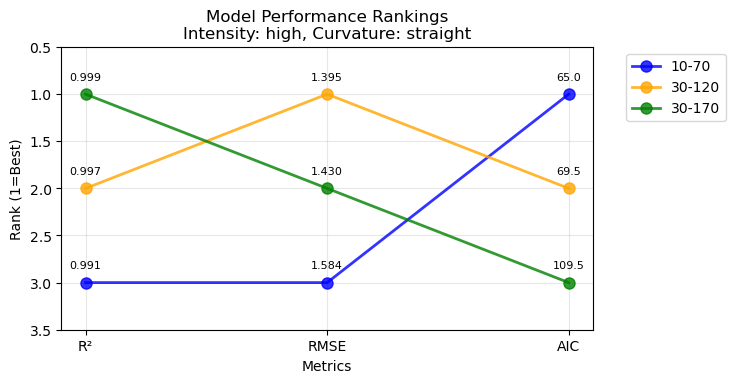

Intensity: low, Curvature: big
Times: ['2025-05-08 15:28:56', '2025-05-08 15:22:56', '2025-05-08 15:40:56', '2025-05-08 15:46:56', '2025-05-08 15:34:56']


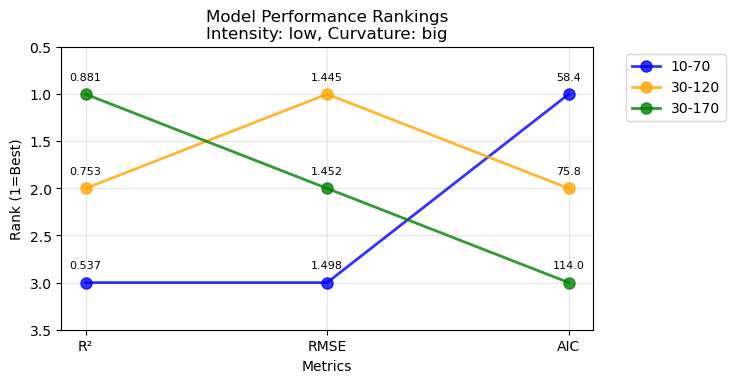

Intensity: low, Curvature: straight
Times: ['2025-05-08 15:43:56', '2025-05-08 15:31:56', '2025-05-08 15:49:56', '2025-05-08 15:37:56', '2025-05-08 15:25:56']


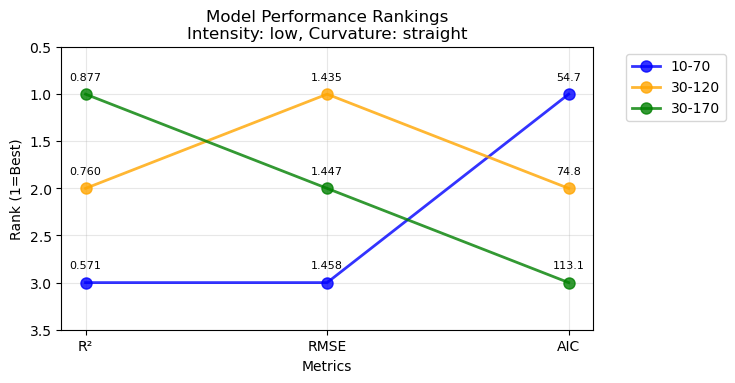

In [133]:
intensities = df_lowcost['intensity'].unique()
curvatures = df_lowcost['curvature'].unique()
metrics_list = ['R2(HM)', 'RMSE(HM)', 'AIC(HM)']
colors = ['blue', 'orange', 'green', 'red', 'purple']
cm = 1/2.54
for intensity in intensities:
    for curvature in curvatures:
        df = df_lowcost[(df_lowcost['intensity'] == intensity) 
                        & (df_lowcost['curvature'] == curvature)]
        ids = df['id'].unique()
        list_of_times = []
        for i in ids:
            df_i = df[df['id'] == i]
            time = df_i['datetime_utc'].values[0]
            list_of_times.append(time)
        
        print(f"Intensity: {intensity}, Curvature: {curvature}")
        print(f"Times: {list_of_times}")
        
        if len(list_of_times) > 0:  # Only plot if we have data
            fig, ax = plt.subplots(figsize=(19*cm, 10*cm))
            
            # Get metric values for each deadband-cutoff combination at these times
            for j, (deadband, cutoff) in enumerate(zip(arbitrary_results['deadband'], arbitrary_results['cutoff'])):
                
                # Collect values for all times in this intensity-curvature group
                r2_values = []
                rmse_values = []
                aic_values = []
                
                for time_str in list_of_times:
                    try:
                        # Convert string time to pandas datetime for matching
                        time_pd = pd.to_datetime(time_str)
                        
                        # Find closest time in dataset
                        time_diff = abs(pd.to_datetime(ds.time.values) - time_pd)
                        closest_time_idx = time_diff.argmin()
                        closest_time = ds.time.values[closest_time_idx]
                        
                        r2 = ds.sel(time=closest_time, deadband=deadband, cutoff=cutoff)['R2(HM)'].values
                        rmse = ds.sel(time=closest_time, deadband=deadband, cutoff=cutoff)['RMSE(HM)'].values
                        aic = ds.sel(time=closest_time, deadband=deadband, cutoff=cutoff)['AIC(HM)'].values
                        
                        r2_values.append(r2)
                        rmse_values.append(rmse)
                        aic_values.append(aic)
                    except:
                        continue
                
                if len(r2_values) > 0:  # Only plot if we have valid data
                    # Calculate average rankings for this parameter combination
                    avg_r2 = np.nanmean(r2_values)
                    avg_rmse = np.nanmean(rmse_values)
                    avg_aic = np.nanmean(aic_values)
                    
                    # Store for ranking calculation
                    if j == 0:  # Initialize on first iteration
                        all_avg_r2 = []
                        all_avg_rmse = []
                        all_avg_aic = []
                        param_labels = []
                    
                    all_avg_r2.append(avg_r2)
                    all_avg_rmse.append(avg_rmse)
                    all_avg_aic.append(avg_aic)
                    param_labels.append(f'{deadband}-{cutoff}')
            
            # Calculate rankings
            if 'all_avg_r2' in locals():
                # For R2: higher is better, so reverse ranking
                # r2_ranks = len(all_avg_r2) + 1 - np.argsort(np.argsort(all_avg_r2)[::-1])
                r2_ranks = np.argsort(np.argsort(all_avg_r2)[::-1]) + 1
                # For RMSE and AIC: lower is better
                rmse_ranks = np.argsort(np.argsort(all_avg_rmse)) + 1
                aic_ranks = np.argsort(np.argsort(all_avg_aic)) + 1
                
                # Create bump chart
                metrics = ['R²', 'RMSE', 'AIC']
                
                for k, param_label in enumerate(param_labels):
                    ranks = [r2_ranks[k], rmse_ranks[k], aic_ranks[k]]
                    ax.plot(metrics, ranks, 'o-', color=colors[k % len(colors)], 
                            linewidth=2, markersize=8, label=param_label, alpha=0.8)
                    
                    # Add value labels on points
                    values = [all_avg_r2[k], all_avg_rmse[k], all_avg_aic[k]]
                    for m, (metric, rank, value) in enumerate(zip(metrics, ranks, values)):
                        if metric == 'R²':
                            value_str = f'{value:.3f}'
                        elif metric == 'RMSE':
                            value_str = f'{value:.3f}'
                        else:
                            value_str = f'{value:.1f}'
                        ax.annotate(value_str, (m, rank), textcoords="offset points", 
                                   xytext=(0,10), ha='center', fontsize=8)
                
                ax.set_ylabel('Rank (1=Best)')
                ax.set_xlabel('Metrics')
                ax.set_title(f'Model Performance Rankings\nIntensity: {intensity}, Curvature: {curvature}')
                ax.grid(True, alpha=0.3)
                ax.invert_yaxis()  # Best rank (1) at top
                ax.set_ylim(len(param_labels) + 0.5, 0.5)
                
                # Legend
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.show()

Intensity: medium, Curvature: big
Times: ['2025-05-08 15:52:56', '2025-05-08 15:58:56', '2025-05-08 16:10:56', '2025-05-08 16:04:56', '2025-05-08 16:16:56']
Intensity: medium, Curvature: straight
Times: ['2025-05-08 16:13:56', '2025-05-08 16:19:56', '2025-05-08 16:01:56', '2025-05-08 15:55:56', '2025-05-08 16:07:56']
Intensity: high, Curvature: big
Times: ['2025-05-08 16:34:56', '2025-05-08 16:46:56', '2025-05-08 16:40:56', '2025-05-08 16:22:56', '2025-05-08 16:28:56']
Intensity: high, Curvature: straight
Times: ['2025-05-08 16:25:56', '2025-05-08 16:37:56', '2025-05-08 16:49:56', '2025-05-08 16:31:56', '2025-05-08 16:43:56']
Intensity: low, Curvature: big
Times: ['2025-05-08 15:28:56', '2025-05-08 15:22:56', '2025-05-08 15:40:56', '2025-05-08 15:46:56', '2025-05-08 15:34:56']
Intensity: low, Curvature: straight
Times: ['2025-05-08 15:43:56', '2025-05-08 15:31:56', '2025-05-08 15:49:56', '2025-05-08 15:37:56', '2025-05-08 15:25:56']


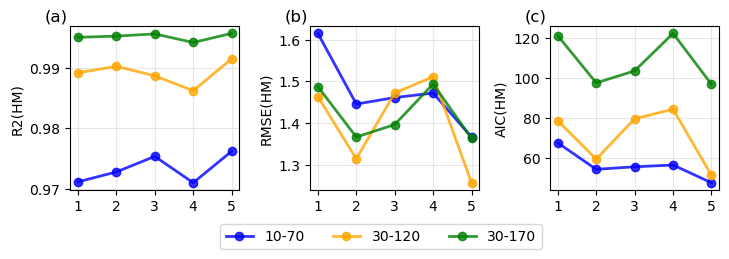

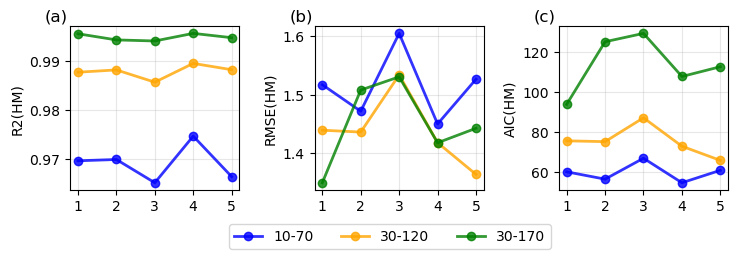

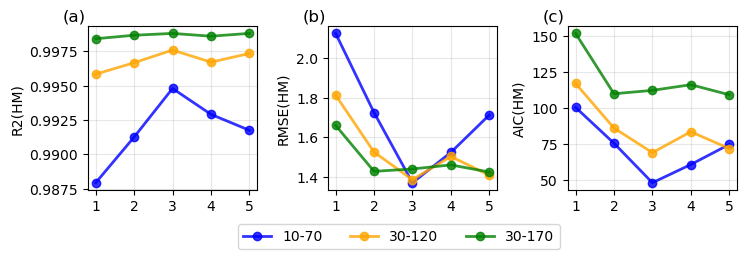

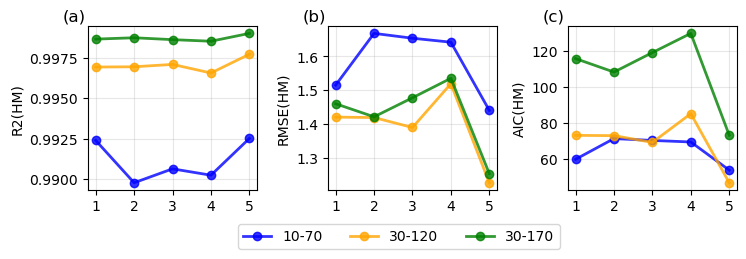

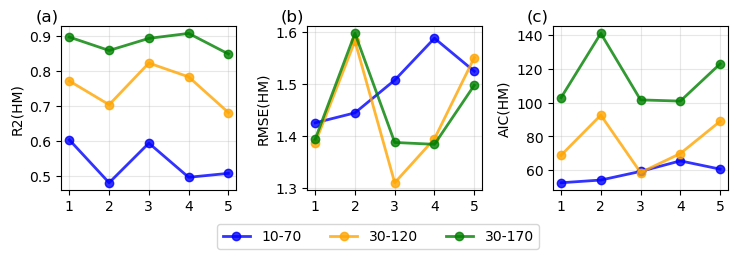

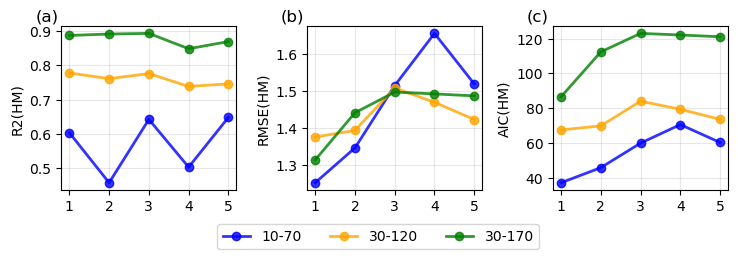

In [134]:
intensities = df_lowcost['intensity'].unique()
curvatures = df_lowcost['curvature'].unique()
metrics_list = ['R2(HM)', 'RMSE(HM)', 'AIC(HM)']
colors = ['blue', 'orange', 'green', 'red', 'purple']
cm = 1/2.54

for intensity in intensities:
    for curvature in curvatures:
        df = df_lowcost[(df_lowcost['intensity'] == intensity) 
                        & (df_lowcost['curvature'] == curvature)]
        ids = df['id'].unique()
        list_of_times = []
        for i in ids:
            df_i = df[df['id'] == i]
            time = df_i['datetime_utc'].values[0]
            list_of_times.append(time)
        
        print(f"Intensity: {intensity}, Curvature: {curvature}")
        print(f"Times: {list_of_times}")
        
        if len(list_of_times) > 0:  # Only plot if we have data
            fig, axes = plt.subplots(1, 3, figsize=(19*cm, 6*cm))
            
            # Convert times to datetime for plotting
            datetime_list = [pd.to_datetime(time_str) for time_str in list_of_times]
            
            for metric_idx, metric in enumerate(metrics_list):
                ax = axes[metric_idx]
                
                # Plot each deadband-cutoff combination
                for j, (deadband, cutoff) in enumerate(zip(arbitrary_results['deadband'], arbitrary_results['cutoff'])):
                    
                    metric_values = []
                    valid_times = []
                    
                    for time_str in list_of_times:
                        try:
                            # Convert string time to pandas datetime for matching
                            time_pd = pd.to_datetime(time_str)
                            
                            # Find closest time in dataset
                            time_diff = abs(pd.to_datetime(ds.time.values) - time_pd)
                            closest_time_idx = time_diff.argmin()
                            closest_time = ds.time.values[closest_time_idx]
                            
                            value = ds.sel(time=closest_time, deadband=deadband, cutoff=cutoff)[metric].values
                            
                            metric_values.append(value)
                            valid_times.append(time_pd)
                        except:
                            continue
                    
                    if len(metric_values) > 0:  # Only plot if we have valid data
                        # Sort by datetime to avoid zig-zags
                        sorted_data = sorted(zip(valid_times, metric_values))
                        sorted_times, sorted_values = zip(*sorted_data) if sorted_data else ([], [])
                        
                        # Create run numbers instead of datetime
                        run_numbers = list(range(1, len(sorted_times) + 1))
                        
                        ax.plot(run_numbers, sorted_values, 'o-', 
                            color=colors[j % len(colors)], 
                            linewidth=2, markersize=6, 
                            label=f'{deadband}-{cutoff}', alpha=0.8)
                
                # Set x-axis with run labels
                if len(list_of_times) > 0:
                    run_labels = [f'{i}' for i in range(1, len(list_of_times) + 1)]
                    ax.set_xticks(range(1, len(list_of_times) + 1))
                    ax.set_xticklabels(run_labels, rotation=0)
                
                ax.set_ylabel(metric)
                ax.grid(True, alpha=0.3)
                
                # Add subplot labels (a), (b), (c) at top left
                subplot_labels = ['(a)', '(b)', '(c)']
                ax.text(-0.15, 1.1, subplot_labels[metric_idx], transform=ax.transAxes, 
                        fontsize=12, 
                        # fontweight='bold', 
                        va='top', ha='left')
                
                # Only show legend on the first subplot

            # Set common x-axis label
            # axes[-1].set_xlabel('Run Number')

            fig.tight_layout()
            if metric_idx == 2:
                ax.legend(bbox_to_anchor=(-1, -.4), loc='lower center', ncol=10)
            fig.show()
